# [1] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
warnings.filterwarnings("ignore")

%matplotlib inline 
# sets the backend of matplotlib to the 'inline' backend:
#With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook,
#directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

#Functions to save objects for later use and retireve it
import pickle
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

C:\Users\Sai charan\Anaconda3\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")
C:\Users\Sai charan\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [2]:
#Using sqlite3 to retrieve data from sqlite file

con = sqlite3.connect("final.sqlite")#Loading Cleaned/ Preprocesed text that we did in Text Preprocessing

#Using pandas functions to query from sql table
final = pd.read_sql_query("""
SELECT * FROM Reviews order by Time
""",con)

#Reviews is the name of the table given
#Taking only the data where score != 3 as score 3 will be neutral and it won't help us much
final.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
2,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
3,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
4,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [3]:
final['Score'] = final['Score'].replace('positive',1)
final['Score'] = final['Score'].replace('negative',0)

In [4]:
final.duplicated(subset={"UserId","ProfileName","Time","Text"}).value_counts()

False    364171
dtype: int64

In [5]:
final =  final.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first")

In [6]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]
print("Size of data",final['Id'].size," rows ")

Size of data 364171  rows 


In [7]:
import re #Regex (Regualar Expr Operations)
#string = r"sdfsdfd" :- r is for raw string as Regex often uses \ backslashes(\w), so they are often raw strings(r’\d’)

########Function to remove html tags from data
def striphtml(data):
    p = re.compile('<.*?>')#Find this kind of pattern
#     print(p.findall(data))#List of strings which follow the regex pattern
    return p.sub('',data) #Substitute nothing at the place of strings which matched the patterns

striphtml('<a href="foo.com" class="bar">I Want This <b>text!</b></a><>')

'I Want This text!'

In [8]:
def strippunc(data):
    p = re.compile(r'[?|!|\'|"|#|.|,|)|(|\|/|~|%|*]')
    return p.sub('',data)
strippunc("fsd*?~,,,( sdfsdfdsvv)#")

'fsd sdfsdfdsvv'

In [9]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = stopwords.words('english') #All the stopwords in English language
#excluding some useful words from stop words list as we doing sentiment analysis
excluding = ['against','not','don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
             'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
             'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",'shouldn', "shouldn't", 'wasn',
             "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
stop = [words for words in stop if words not in excluding]
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's',

In [10]:
from nltk.stem import SnowballStemmer
snow = SnowballStemmer('english') #initialising the snowball stemmer
print("Stem/Root words of the some of the words using SnowBall Stemmer:")
print(snow.stem('tasty'))
print(snow.stem('tasteful'))
print(snow.stem('tastiest'))
print(snow.stem('delicious'))
print(snow.stem('amazing'))
print(snow.stem('amaze'))
print(snow.stem('initialize'))
print(snow.stem('fabulous'))
print(snow.stem('Honda City'))
print(snow.stem('unpleasant'

))

Stem/Root words of the some of the words using SnowBall Stemmer:
tasti
tast
tastiest
delici
amaz
amaz
initi
fabul
honda c
unpleas


In [11]:
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'][2:3].values: #Running only for 2nd review
    filtered_sentence=[]
    print(sent) #Each review
    sent=striphtml(sent)# remove HTMl tags
    sent=strippunc(sent)# remove Punctuation Symbols
    print(sent.split())
    for w in sent.split():
        print("================================>",w)
        if((w.isalpha()) and (len(w)>2)):#If it is a numerical value or character of lenght less than 2    
            if(w.lower() not in stop):# If it is a stopword
                s=(snow.stem(w.lower())).encode('utf8') #Stemming the word using SnowBall Stemmer
                print("Selected: Stem Word->",s)
                filtered_sentence.append(s)
            else:
                print("Eliminated as it is a stopword")
                continue
        else:
            print("Eliminated as it is a numerical value or character of lenght less than 2")
            continue 
#     print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    print("***********************************************************************")
    print("Finally selected words from the review:\n",final_string)

Beetlejuice is a well written movie ..... everything about it is excellent! From the acting to the special effects you will be delighted you chose to view this movie.
['Beetlejuice', 'is', 'a', 'well', 'written', 'movie', 'everything', 'about', 'it', 'is', 'excellent', 'From', 'the', 'acting', 'to', 'the', 'special', 'effects', 'you', 'will', 'be', 'delighted', 'you', 'chose', 'to', 'view', 'this', 'movie']
================================> Beetlejuice
Selected: Stem Word-> b'beetlejuic'
================================> is
Eliminated as it is a numerical value or character of lenght less than 2
================================> a
Eliminated as it is a numerical value or character of lenght less than 2
================================> well
Selected: Stem Word-> b'well'
================================> written
Selected: Stem Word-> b'written'
================================> movie
Selected: Stem Word-> b'movi'
================================> everything
Selected: Stem Word-> b'every

In [12]:
%%time
# Code takes a while to run as it needs to run on around 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
#     print(sent) #Each review
    sent=striphtml(sent)# remove HTMl tags
    sent=strippunc(sent)# remove Punctuation Symbols
#     print(sent.split())
    for w in sent.split():
#         print("================================>",w)
        if((w.isalpha()) and (len(w)>2)):#If it is a numerical value or character of lenght less than 2    
            if(w.lower() not in stop):# If it is a stopword
                s=(snow.stem(w.lower())).encode('utf8') #Stemming the word using SnowBall Stemmer
                                        #encoding as byte-string/utf-8
#                 print("Selected: Stem Word->",s)
                filtered_sentence.append(s)
                if (final['Score'].values)[i] == 'Positive': 
                    all_positive_words.append(s) #list of all words used to describe positive reviews
                if(final['Score'].values)[i] == 'Negative':
                    all_negative_words.append(s) #list of all words used to describe negative reviews reviews
            else:
#                 print("Eliminated as it is a stopword")
                continue
        else:
#             print("Eliminated as it is a numerical value or character of lenght less than 2")
            continue 
#     print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
            #encoding as byte-string/utf-8
    
    final_string.append(str1)
#     print("***********************************************************************")
#     print("Finally selected words from the review:\n",final_string)
    i+=1

Wall time: 24min 1s


In [13]:
%%time
# Code takes a while to run as it needs to run on around 500k sentences.
i=0
str1=' '
final_string_nostem=[]
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=striphtml(sent)# remove HTMl tags
    sent=strippunc(sent)# remove Punctuation Symbols
    for w in sent.split():
        if((w.isalpha()) and (len(w)>2)):#If it is a numerical value or character of lenght less than 2    
            if(w.lower() not in stop):# If it is a stopword
                s=w.lower().encode('utf8') #encoding as byte-string/utf-8
            else:
                continue
        else:
            continue 
    str1 = b" ".join(filtered_sentence)     
    final_string_nostem.append(str1)
    i+=1

Wall time: 2min 41s


In [14]:
#Adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final_string
final['CleanedText_NoStem']=final_string_nostem
final.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...,b''
1,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...,b''
2,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...,b''


In [15]:
final = final.sample(100000)

In [16]:
final.sort_values('Time',inplace=True) 
final.head(10)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
2,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...,b''
14,138001,149770,B00004S1C5,A1KXONFPU2XQ5K,Stephanie Manley,8,8,1,965779200,Very easy to use,This are so much easier to use than the Wilson...,b'much easier use wilson past color color vibr...,b''
16,346115,374421,B00004CI84,A1FJOY14X3MUHE,Justin Howard,2,2,1,966297600,"A fresh, original film from master storyteller...","This is such a great film, I don't even know h...",b'great film dont even know sum first complet ...,b''
17,346102,374408,B00004CI84,A1GB1Q193DNFGR,Bruce Lee Pullen,5,5,1,970531200,Fabulous Comedic Fanasy Directed by a Master,Beetlejuice is an awe-inspiring wonderfully am...,b'beetlejuic wonder amus comed romp explor inc...,b''
20,346054,374358,B00004CI84,A1HWMNSQF14MP8,will@socialaw.com,1,2,1,978134400,A Afterlife Success,"Many movies, have dealt with the figure of dea...",b'mani movi dealt figur death dead good angel ...,b''
21,138018,149790,B00004S1C6,A1IU7S4HCK1XK0,Joanna Daneman,25,27,1,982800000,Make your own Martha Stewart style cakes and c...,I don't know why anyone would ever use those l...,b'dont know anyon would ever use littl liquid ...,b''
29,346032,374334,B00004CI84,A2HIZRVOKXKZ52,KAY N. FOWLER,0,0,1,1012780800,Beetlejuice - Great Fun for Everyone!,When vacationing Adam and Barbara Maitland mee...,b'vacat adam barbara maitland meet demis kill ...,b''
32,346030,374332,B00004CI84,AEPJYN0NAX9N4,Jody L. Schoth,0,0,1,1014163200,Excellent... Hilarious,Just hilarious... my favorite part is the dini...,b'hilari favorit part dine room scene sing dan...,b''
34,346113,374419,B00004CI84,ADIDQRLLR4KBQ,"""paradise_found""",2,2,1,1015545600,Because My Middle Name is &quot;Weird&quot;,"Set in a small New England town, Tim Burton's ...",b'set small new england town tim burton master...,b''
41,346053,374357,B00004CI84,A31RM5QU797HPJ,Drez,1,2,1,1024531200,"&quot;I'm the ghost with the most, babe&quot;",Simply put: Beetlejuice is the funniest comedy...,b'simpli beetlejuic funniest comedi kind sinc ...,b''


In [17]:
savetofile(final,"sample_lr")

In [18]:
final = openfromfile("sample_lr")

# [7.2.2] Bag of Words (BoW)

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(final['CleanedText'].values,final['Score'].values,test_size=0.3,shuffle=False)

#Text -> Uni gram Vectors
uni_gram = CountVectorizer() 
X_train = uni_gram.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = uni_gram.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (70000, 67222)
Test Data Size:  (30000, 67222)


In [20]:
#To show how Time Series Split splits the data
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train):
#     print("%s %s" % (train, cv))
    print(X_train[train].shape, X_train[cv].shape)

(6370, 67222) (6363, 67222)
(12733, 67222) (6363, 67222)
(19096, 67222) (6363, 67222)
(25459, 67222) (6363, 67222)
(31822, 67222) (6363, 67222)
(38185, 67222) (6363, 67222)
(44548, 67222) (6363, 67222)
(50911, 67222) (6363, 67222)
(57274, 67222) (6363, 67222)
(63637, 67222) (6363, 67222)


In [21]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
savetofile(gsv,"Log Reg/gsv_uni")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 15.7min finished


Best HyperParameter:  {'C': 10, 'penalty': 'l2'}
Best Accuracy: 91.48%


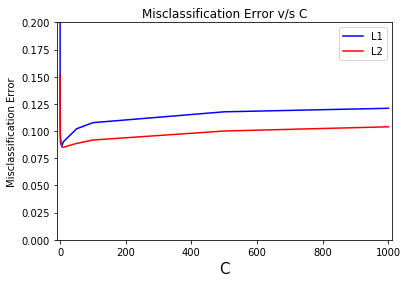

In [22]:
def plot_error_vs_c(gsv):
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    for a in gsv.grid_scores_:
        if (a[0]['penalty']) == 'l1':
            y1.append(1-a[1])
            x1.append(a[0]['C'])
        else:
            y2.append(1-a[1])
            x2.append(a[0]['C'])
    plt.xlim(-10,1010)
    plt.ylim(0,0.2)
    plt.xlabel("C",fontsize=15)
    plt.ylabel("Misclassification Error")
    plt.title('Misclassification Error v/s C')
    plt.plot(x1,y1,'b',label="L1")
    plt.plot(x2,y2,'r',label="L2")
    plt.legend()
    plt.show()
gsv = openfromfile("Log Reg/gsv_uni")
plot_error_vs_c(gsv)

Accuracy on test set: 91.520%
Precision on test set: 0.932
Recall on test set: 0.968
F1-Score on test set: 0.950
Non Zero weights: 67222
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



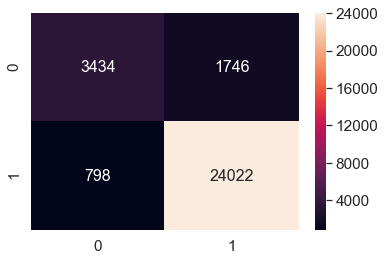

In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Showing how sparsity increases as we increase lambda or decrease C when L1 Regularizer is used

In [24]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1000, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 85.900%
F1-Score on test set: 0.915
Non Zero weights: 16162


In [25]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 100, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test

, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 88.960%
F1-Score on test set: 0.934
Non Zero weights: 12716


In [26]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.220%
F1-Score on test set: 0.948
Non Zero weights: 5901


In [27]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.260%
F1-Score on test set: 0.948
Non Zero weights: 1043


In [28]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 88.683%
F1-Score on test set: 0.935
Non Zero weights: 192


In [29]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.01, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 82.990%
F1-Score on test set: 0.907
Non Zero weights: 12




We can see how drastically the sparsity increases from 13861 non-zero weights(@ C=1000) to only 12 non-zero weights(@ C=0.01) when we use L1 Regularization
Using Randomized Search CV to find best parameters

In [30]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = { 'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
              'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
savetofile(gsv,"Log Reg/gsv_uni_r")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  5.9min finished


Best HyperParameter:  {'penalty': 'l2', 'C': 10}
Best Accuracy: 91.48%


Accuracy on test set: 91.540%
Precision on test set: 0.931
Recall on test set: 0.970
F1-Score on test set: 0.950
Non Zero weights: 67222
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



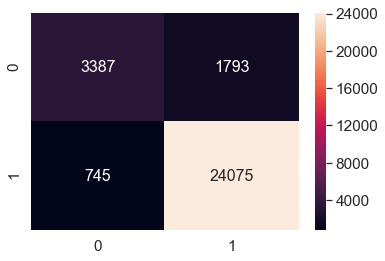

In [31]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 5, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

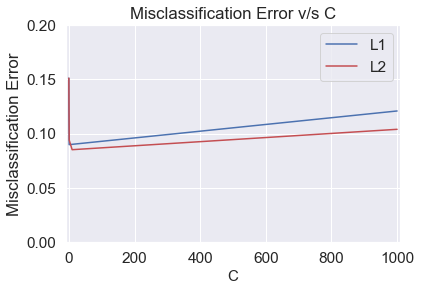

In [32]:
def plot_error_vs_c_r(gsv):
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    for a in gsv.grid_scores_:
        if (a[0]['penalty']) == 'l1':
            y1.append(1-a[1])
            x1.append(a[0]['C'])
        else:
            y2.append(1-a[1])
            x2.append(a[0]['C'])

    ind1 = np.argsort(x1)
    x1=np.array(x1)
    y1=np.array(y1)
    ind2 = np.argsort(x2)
    x2=np.array(x2)
    y2=np.array(y2)
    plt.xlim(-10,1010)
    plt.ylim(0,0.2)
    plt.xlabel("C",fontsize=15)
    plt.ylabel("Misclassification Error")
    plt.title('Misclassification Error v/s C')
    plt.plot(x1[ind1],y1[ind1],'b',label="L1")
    plt.plot(x2[ind2],y2[ind2],'r',label="L2")
    plt.legend()
    plt.show()
gsv = openfromfile("Log Reg/gsv_uni_r")
plot_error_vs_c_r(gsv)

Perturbation Test

In [33]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.520%
Non Zero weights: 67222


In [34]:
from scipy.sparse import find
#Weights before adding random noise
weights1 = find(clf.coef_[0])[2]
print(weights1[:50])

[ 6.15102136e-01  5.51515061e-04 -4.83691241e-01  3.19053598e-04
  2.31122851e-02  2.31122851e-02  8.40310670e-03  5.84255701e-03
  7.74631981e-03  1.65145668e-02  4.41763292e-02  3.34143641e-04
  8.25588389e-04  5.20033375e-02  2.67408205e-02  1.23340960e-03
  1.08914358e-02 -4.22694267e-01  1.15138183e-02  8.91828846e-02
  1.11423962e-01  6.02835785e-01  1.71586517e+00 -3.76046683e-02
 -1.83565180e+00 -6.09771907e-01  2.77869119e-03  2.22239157e-01
  3.44068941e-02  1.10986208e-01  8.35684781e-02  4.30898707e-02
  1.42644698e-02 -2.59818546e-02  9.85762548e-01 -1.73468665e-01
 -8.73255074e-01  1.39875447e-02  8.60950141e-02 -8.67920652e-01
  3.04345182e-03  2.65919666e-02 -2.69469874e-04 -6.60990342e-03
  4.43122107e-03  3.38111976e-01  4.17929483e-03  6.46828746e-02
  4.74990143e-03  2.14376220e-01]


In [35]:
X_train_t = X_train
#Random noise
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_t)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_t)

#Introducing random noise to non-zero datapoints
X_train_t[a,b] = epsilon + X_train_t[a,b]

In [36]:
#Training on train data having random noise
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train_t,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 91.520%
Non Zero weights: 67222


In [37]:
from scipy.sparse import find
#Weights after adding random noise
weights2 = find(clf.coef_[0])[2]
print(weights2[:50])

[ 6.14883330e-01  5.51432483e-04 -4.83171444e-01  3.18358801e-04
  2.30901279e-02  2.30839137e-02  8.41071192e-03  5.83928095e-03
  7.74502769e-03  1.64921320e-02  4.42126298e-02  3.34471251e-04
  8.25732941e-04  5.20183876e-02  2.68372114e-02  1.23295290e-03
  1.08808763e-02 -4.22607678e-01  1.15080313e-02  8.90639423e-02
  1.11348320e-01  6.02927199e-01  1.71576633e+00 -3.76123780e-02
 -1.83694573e+00 -6.09834581e-01  2.76772572e-03  2.22171953e-01
  3.43653618e-02  1.10952194e-01  8.37217580e-02  4.31502601e-02
  1.43272682e-02 -2.59850089e-02  9.85805802e-01 -1.73294272e-01
 -8.73817060e-01  1.39538605e-02  8.61348484e-02 -8.67441964e-01
  3.03817964e-03  2.66137035e-02 -2.96280407e-04 -6.59805066e-03
  4.43510092e-03  3.38396507e-01  4.18548240e-03  6.46331641e-02
  4.75140192e-03  2.14232153e-01]


In [38]:
print(weights2.size)

67222


In [39]:
weights_diff = (abs(weights1 - weights2)/weights1) * 100

In [40]:
print(weights_diff[np.where(weights_diff > 30)].size)

6


## [7.2.4] Bi-Grams and n-Grams.

**Motivation**

Now that we have our list of words describing positive and negative reviews lets analyse them.<br>

We begin analysis by getting the frequency distribution of the words as shown below

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(final['CleanedText'].values,final['Score'].values,test_size=0.3,shuffle=False)

#taking one words and two consecutive words together
bi_gram = CountVectorizer(ngram_range=(1,2)) 
X_train = bi_gram.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = bi_gram.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (70000, 1066892)
Test Data Size:  (30000, 1066892)


In [42]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
savetofile(gsv,"Log Reg/gsv_bi")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 23.2min finished


Best HyperParameter:  {'C': 1000, 'penalty': 'l2'}
Best Accuracy: 92.41%


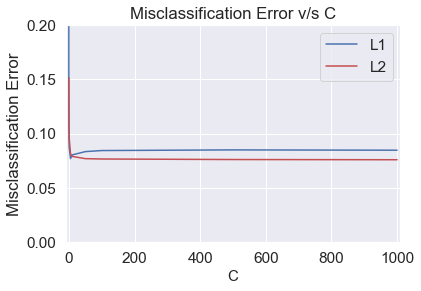

In [43]:
gsv = openfromfile("Log Reg/gsv_bi")
plot_error_vs_c(gsv)

Accuracy on test set: 92.887%
Precision on test set: 0.943
Recall on test set: 0.973
F1-Score on test set: 0.958
Non Zero weights: 1066892
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



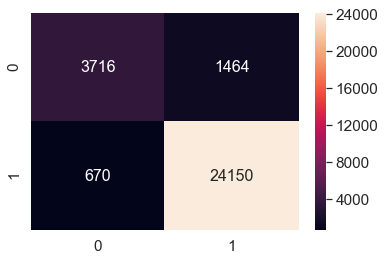

In [44]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 100, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Showing how sparsity increases as we increase lambda or decrease C when L1 Regularizer is used

In [45]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1000, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 92.017%
F1-Score on test set: 0.952
Non Zero weights: 16235


In [46]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 100, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 92.017%
F1-Score on test set: 0.952
Non Zero weights: 12587


In [47]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 92.370%
F1-Score on test set: 0.954
Non Zero weights: 8093


In [48]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 92.080%
F1-Score on test set: 0.953
Non Zero weights: 988


In [49]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 88.387%
F1-Score on test set: 0.933
Non Zero weights: 157


In [50]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.01, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 82.863%
F1-Score on test set: 0.906
Non Zero weights: 7




We can see how drastically the sparsity increases from 52309 non-zero weights(@ C=1000) to only 55 non-zero weights(@ C=0.01) when we use L1 Regularization
Using Randomized Search CV to find best parameters

In [51]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
              'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
savetofile(gsv,"Log Reg/gsv_bi_r")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  7.4min finished


Best HyperParameter:  {'penalty': 'l2', 'C': 50}
Best Accuracy: 92.31%


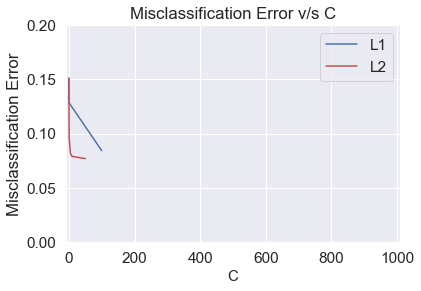

In [52]:
gsv = openfromfile("Log Reg/gsv_bi_r")
plot_error_vs_c_r(gsv)

Accuracy on test set: 92.887%
Precision on test set: 0.943
Recall on test set: 0.973
F1-Score on test set: 0.958
Non Zero weights: 1066892
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



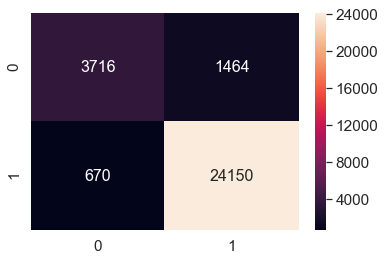

In [53]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 100, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Perturbation Test

In [54]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 500, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 92.873%
Non Zero weights: 1066892


In [55]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 500, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 92.873%
Non Zero weights: 1066892


In [56]:
from scipy.sparse import find
#Weights before adding random noise
weights1 = find(clf.coef_[0])[2]
print(weights1[:50])

[ 1.25706174e+00  6.69879822e-02  5.07612582e-01  5.98663762e-01
  1.61048512e-04  1.61048512e-04 -6.25396504e-01 -6.25396504e-01
  1.17634541e-03  1.17634541e-03  3.95124780e-02  3.95124780e-02
  3.95124780e-02  3.95124780e-02  3.23814354e-03  3.23814354e-03
  1.01350275e-02  1.01350275e-02  2.09814713e-02  2.09814713e-02
  3.03064661e-02  3.03064661e-02  3.68823313e-02  3.68823313e-02
  3.15836742e-04  3.15836742e-04  3.58041144e-04  1.31750814e-01
  1.31750814e-01  4.91985245e-02  3.89083709e-03  2.18000684e-01
 -1.72692997e-01  2.08978672e-03  2.08978672e-03  6.16863835e-03
  6.16863835e-03 -2.32846181e-01 -2.32846181e-01  5.48441601e-03
  5.48441601e-03  6.07715552e-02  4.82379666e-02  1.25335885e-02
  3.90021912e-01  3.90021912e-01  6.63501173e-01  4.60476844e-05
  2.21136359e-01  4.42272718e-01]


In [57]:
X_train_t = X_train
#Random noise
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_t)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_t)

#Introducing random noise to non-zero datapoints
X_train_t[a,b] = epsilon + X_train_t[a,b]

In [58]:
#Training on train data having random noise
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train_t,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 92.713%
Non Zero weights: 1066892


In [59]:
from scipy.sparse import find
#Weights after adding random noise
weights2 = find(clf.coef_[0])[2]
print(weights2[:50])

[ 3.74402234e-01  2.14615700e-02  1.39345538e-01  1.74278155e-01
  1.70830678e-04  1.70786265e-04 -2.17387375e-01 -2.17426011e-01
  1.92216067e-03  1.91961115e-03  1.00240433e-02  1.00773595e-02
  1.00400738e-02  1.00688297e-02  4.32314641e-03  4.32678973e-03
  1.09229924e-02  1.09294153e-02  5.27996576e-03  5.26008826e-03
  1.41473683e-02  1.41465061e-02  1.22710341e-02  1.22761700e-02
  5.19983830e-04  5.19113248e-04  6.58206918e-04  4.66236663e-02
  4.66280761e-02  3.07081260e-02  5.84466606e-03  6.23972625e-02
 -3.76137147e-02  3.37909438e-03  3.38230070e-03  6.87136499e-03
  6.86999766e-03 -8.71127513e-02 -8.70644065e-02  8.54184810e-03
  8.53590157e-03  3.38209530e-02  2.45876782e-02  9.26437021e-03
  1.14309843e-01  1.14356309e-01  2.53273022e-01  4.39799154e-05
  8.44971796e-02  1.68775028e-01]


In [60]:
print(weights2.size)

1066892


In [61]:
weights_diff = (abs(weights1 - weights2)/weights1) * 100

In [62]:
print(weights_diff[np.where(weights_diff > 30)].size)

684658




526050 features have weight changes greater than 30%. Hence the features are multicollinear
Feature Importance[Top 25]

In [63]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(bi_gram,clf)

			Positive						Negative
________________________________________________________________________________________________
	-16.5223	worst          				15.7354	not disappoint 
	-14.1624	disappoint     				12.9754	delici         
	-13.1949	not worth      				10.8029	perfect        
	-13.0976	terribl        				10.6946	high recommend 
	-11.9867	aw             				10.2774	best           
	-11.3426	horribl        				9.6109	wont disappoint
	-10.6609	not good       				9.5170	amaz           
	-10.1731	not recommend  				9.4466	not bad        
	-10.0430	bland          				9.3502	excel          
	-9.9911	unfortun       				8.9763	great          
	-9.8742	return         				8.8212	addict         
	-9.1450	disgust        				8.4884	awesom         
	-8.7924	not happi      				8.3882	happi          
	-8.7496	weak           				8.1093	favorit        
	-8.5958	rip            				8.0813	not bitter     
	-8.5774	stale          				7.8032	yummi          
	-8.3950	ruin           				7.6154	nice        

# [7.2.5] TF-IDF

In [64]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(final['CleanedText'].values,final['Score'].values,test_size=0.3,shuffle=False)

tfidf = TfidfVectorizer(ngram_range=(1,2)) #Using bi-grams
X_train = tfidf.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = tfidf.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (70000, 1066892)
Test Data Size:  (30000, 1066892)
Wall time: 20.7 s


In [65]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
savetofile(gsv,"Log Reg/gsv_tfidf")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 25.8min finished


Best HyperParameter:  {'C': 5, 'penalty': 'l1'}
Best Accuracy: 92.29%


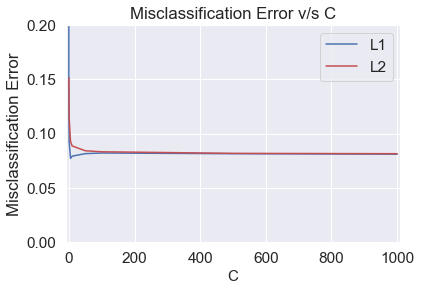

In [66]:
gsv = openfromfile("Log Reg/gsv_tfidf")
plot_error_vs_c(gsv)

Accuracy on test set: 92.720%
Precision on test set: 0.946
Recall on test set: 0.967
F1-Score on test set: 0.956
Non Zero weights: 5969
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



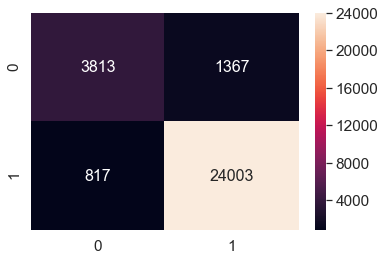

In [67]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 5, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Showing how sparsity increases as we increase lambda or decrease C when L1 Regularizer is use

In [68]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1000, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 92.260%
F1-Score on test set: 0.954
Non Zero weights: 19526


In [69]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 100, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 92.340%
F1-Score on test set: 0.954
Non Zero weights: 14332


In [70]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 92.530%
F1-Score on test set: 0.955
Non Zero weights: 9746


In [71]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 92.037%
F1-Score on test set: 0.953
Non Zero weights: 890


In [72]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 87.287%
F1-Score on test set: 0.928
Non Zero weights: 95


In [73]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.01, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 82.733%
F1-Score on test set: 0.906
Non Zero weights: 1




We can see how drastically the sparsity increases from 62771 non-zero weights(@ C=1000) to only 20 non-zero weights(@ C=0.01) when we use L1 Regularization
Using Randomized Search CV to find best parameters

In [74]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
              ,'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
savetofile(gsv,"Log Reg/gsv_tfidf_r")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  6.2min finished


Best HyperParameter:  {'penalty': 'l2', 'C': 500}
Best Accuracy: 91.82%


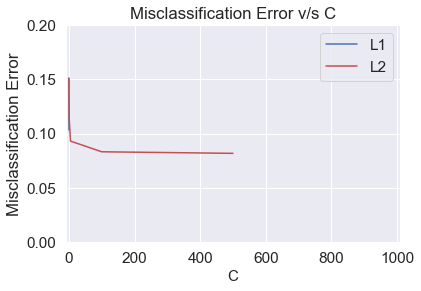

In [75]:
gsv = openfromfile("Log Reg/gsv_tfidf_r")
plot_error_vs_c_r(gsv)

Accuracy on test set: 92.717%
Precision on test set: 0.946
Recall on test set: 0.967
F1-Score on test set: 0.956
Non Zero weights: 5976
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



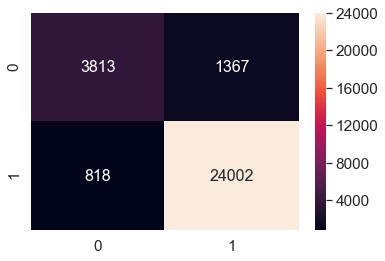

In [76]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 5, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Perturbation Test

In [77]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 500, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 92.907%
Non Zero weights: 1066892


In [78]:
from scipy.sparse import find
#Weights before adding random noise
weights1 = find(clf.coef_[0])[2]
print(weights1[:50])

[ 1.20816701e+00  9.38765695e-02  5.17757266e-01  5.53209722e-01
  2.92320872e-03  2.92320872e-03 -6.74452688e-01 -6.74452688e-01
  1.55250325e-02  1.55250325e-02  5.55327019e-02  5.55327019e-02
  5.55327019e-02  5.55327019e-02  1.70719600e-02  1.70719600e-02
  4.63536584e-02  4.63536584e-02  1.60534798e-02  1.60534798e-02
  5.75583594e-02  5.75583594e-02  3.82398203e-02  3.82398203e-02
  3.15058285e-03  3.15058285e-03  5.55680118e-03  2.26184732e-01
  2.26184732e-01  2.30564952e-02  1.77816921e-02  2.07475970e-01
 -2.00717268e-01  1.73803888e-02  1.73803888e-02  3.56346277e-02
  3.56346277e-02 -4.28928023e-01 -4.28928023e-01  3.62447592e-02
  3.62447592e-02  8.90369074e-02  7.44945859e-02  1.78071518e-02
  4.20985128e-01  4.20985128e-01  8.08028408e-01  8.53080730e-04
  2.78650420e-01  5.57300839e-01]


In [79]:
print(weights1[weights1<=0.0001])

[-0.67445269 -0.67445269 -0.20071727 ... -1.20979016 -0.48444084
 -0.48444084]


In [80]:
X_train_t = X_train
#Random noise
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_t)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_t)

#Introducing random noise to non-zero datapoints
X_train_t[a,b] = epsilon + X_train_t[a,b]

In [81]:
#Training on train data having random noise
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train_t,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 92.683%
Non Zero weights: 1066892


In [82]:
from scipy.sparse import find
#Weights after adding random noise
weights2 = find(clf.coef_[0])[2]
print(weights2[:50])

[ 4.24785125e-01  4.53498601e-02  1.65247823e-01  1.85965491e-01
  6.71829405e-04  6.71324053e-04 -2.53574115e-01 -2.53395328e-01
  9.69315139e-03  9.68622721e-03  1.89896910e-02  1.89618380e-02
  1.89165895e-02  1.89794169e-02  1.07029850e-02  1.06993201e-02
  2.71921331e-02  2.71700551e-02  7.66728731e-03  7.69270957e-03
  2.69534482e-02  2.69515313e-02  1.92176032e-02  1.92205658e-02
  1.38266202e-03  1.38294828e-03  3.24149748e-03  8.71115923e-02
  8.71019177e-02  1.04469702e-02  1.05652614e-02  6.66340688e-02
 -6.59101009e-02  1.09499594e-02  1.09464881e-02  2.11104412e-02
  2.11211841e-02 -1.76134912e-01 -1.76221298e-01  2.17046458e-02
  2.17109160e-02  4.42320383e-02  3.49966193e-02  1.08862297e-02
  1.38557963e-01  1.38567264e-01  2.98443742e-01  1.52541971e-04
  1.03016765e-01  2.06186618e-01]


In [83]:
print(weights2.size)

1066892


In [84]:
weights_diff = (abs(weights1 - weights2)/weights1) * 100

In [85]:
print(weights_diff[np.where(weights_diff > 30)].size)

809309




531188 features have weight changes greater than 30%. Hence the features are multicollinear
Feature Importance[Top 25]

In [86]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(tfidf,clf)

			Positive						Negative
________________________________________________________________________________________________
	-20.6065	disappoint     				21.6930	great          
	-16.5653	worst          				18.4893	best           
	-14.2974	terribl        				18.4624	delici         
	-13.8435	not            				17.4984	love           
	-13.0087	aw             				15.2083	perfect        
	-12.4238	not worth      				14.2617	good           
	-12.2793	horribl        				13.3432	not disappoint 
	-12.1922	return         				12.2458	excel          
	-11.5883	not good       				12.1149	favorit        
	-11.4083	unfortun       				12.0257	nice           
	-10.6083	bland          				10.9851	happi          
	-10.3454	not recommend  				10.7168	amaz           
	-9.7239	stale          				10.5353	high recommend 
	-9.5233	disgust        				9.8379	tasti          
	-9.4237	not buy        				9.3881	keep           
	-9.3139	weak           				9.2474	wonder         
	-9.2798	wast           				8.7465	a

# [7.2.6] Word2Vec

In [87]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need
is_your_ram_gt_16g=False
want_to_read_sub_set_of_google_w2v = True
want_to_read_whole_google_w2v = True
if not is_your_ram_gt_16g:
    if want_to_read_sub_set_of_google_w2v and  os.path.isfile('google_w2v_for_amazon.pkl'):
        with open('google_w2v_for_amazon.pkl', 'rb') as f:
            # model is dict object, you can directly access any word vector using model[word]
            model = pickle.load(f)
else:
    if want_to_read_whole_google_w2v and os.path.isfile('GoogleNews-vectors-negative300.bin'):
        model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# print("the vector representation of word 'computer'",model.wv['computer'])
# print("the similarity between the words 'woman' and 'man'",model.wv.similarity('woman', 'man'))
# print("the most similar words to the word 'woman'",model.wv.most_similar('woman'))
# this will raise an error
# model.wv.most_similar('tasti')  # "tasti" is the stemmed word for tasty, tastful

In [88]:
final_string = []
for sent in final['CleanedText'].values:
    sent = str(sent)
    sentence=[]
#     print(sent)
    for word in sent.split():
#         print(word)
        sentence.append(word)
#         print(sentence)
    final_string.append(sentence)

In [89]:
%%time
# Train your own Word2Vec model using your own text corpus
import gensim

w2v_model=gensim.models.Word2Vec(final_string,min_count=5,size=50, workers=-1)
#min-count: Ignoring the words which occurs less than 5 times
#size:Creating vectors of size 50 for each word
#workers: Use these many worker threads to train the model (faster training with multicore machines)

Wall time: 2.25 s


In [90]:
w2v_model.save('w2vmodel')

In [91]:
w2v_model = gensim.models.Word2Vec.load('w2vmodel')

In [92]:
w2v_vocub = w2v_model.wv.vocab
len(w2v_vocub)

17003

In [93]:
w2v_model.wv.most_similar('like')

[('elicit', 0.505842387676239),
 ('mercken', 0.48501843214035034),
 ('goo', 0.47896409034729004),
 ('casino', 0.46993979811668396),
 ('placebo', 0.46269136667251587),
 ('gusher', 0.4538058638572693),
 ("man'", 0.44946178793907166),
 ('individu', 0.44511187076568604),
 ('ppm', 0.4363514184951782),
 ('fahrenheit', 0.43372035026550293)]

avg w2c

In [94]:
%%time
avg_vec = [] #List to store all the avg w2vec's 
for sent in final_string[0:1]:
    cnt = 0 #to count no of words in each reviews
    sent_vec = np.zeros(50) #Initializing with zeroes
    print("sent:",sent) 
    for word in sent:
        try:
            wvec = w2v_model.wv[word] #Vector of each using w2v model
            print("wvec:",wvec)
            sent_vec += wvec #Adding the vectors 
            cnt += 1
        except: 
            pass #When the word is not in the dictionary then do nothing 
    print("sent_vec:",sent_vec)    
    a_vec =sent_vec / cnt #Taking average of vectors sum of the particular review
    print("avg_vec:",a_vec)
    avg_vec.append(a_vec) #Storing the avg w2vec's for each review
    print("*******************************************************************")

sent: ["b'beetlejuic", 'well', 'written', 'movi', 'everyth', 'excel', 'act', 'special', 'effect', 'delight', 'chose', 'view', "movi'"]
wvec: [ 7.5316434e-03  5.5963541e-03  3.3668838e-03 -4.2805593e-03
 -2.9120480e-03 -3.2141963e-03  8.4102614e-04 -9.5801363e-03
  4.4790427e-03 -6.5345623e-05 -2.4252303e-03  5.1468466e-03
 -2.9293478e-03 -2.4146333e-03 -3.6520234e-03  7.7118026e-03
  2.6485333e-03  8.3531179e-03  8.4725358e-03 -1.6064959e-03
 -3.2234262e-04  7.3426478e-03 -4.1665654e-03 -4.8202211e-03
  2.6336233e-03  6.5445341e-03 -1.8406125e-03  1.7445676e-03
  7.4103847e-03  9.8837344e-03  8.1946589e-03 -5.6885593e-03
  3.5055701e-03  3.7598643e-03 -5.1132976e-03 -2.4040823e-03
  4.0212716e-03  9.6622752e-03 -8.9411583e-04  4.6861535e-03
  5.2383342e-03  3.2225323e-03 -9.9584255e-03  6.7928801e-03
  9.4951373e-03  2.0522028e-04  1.9341683e-03  9.5971152e-03
  3.8014690e-03 -5.0387639e-03]
wvec: [ 0.0062303  -0.00597255 -0.00167299  0.00761241  0.00425581  0.0007935
  0.00563108  0.0

  4.3916716e-03 -2.7027524e-03]
wvec: [ 4.3092440e-03 -3.2940528e-03  5.0991843e-03 -5.9517068e-03
  4.5143245e-03 -7.4505043e-04 -6.6505536e-03 -2.9312579e-03
  5.9747184e-03  1.1354795e-03  6.3280808e-03  2.0548713e-03
 -6.1560292e-03 -5.1729265e-03  5.8165258e-03  7.1112742e-03
  1.1806840e-04 -5.5588367e-03 -2.4084435e-04 -3.5781264e-03
 -3.1389508e-03 -8.8799186e-03 -3.9593000e-03  4.6442486e-03
  8.4536495e-03  1.5066774e-03  3.7034566e-03 -5.9905309e-05
 -7.3028961e-03  6.8518403e-03  5.4807654e-03 -7.3600304e-03
  4.0080664e-03  5.6732949e-03 -7.1108616e-03  5.9694420e-03
  3.9995792e-03 -4.7078016e-03 -9.4131362e-03 -7.2243414e-03
  6.4578322e-03 -2.2723537e-03  7.9880320e-03 -8.0465740e-03
 -4.1971579e-03 -7.9078861e-03  4.6546054e-03  3.3289910e-04
 -7.6149325e-03 -5.7071443e-03]
sent_vec: [ 0.03766104 -0.04168858 -0.00288994  0.00048642  0.00575901  0.01645754
  0.02302818 -0.00388488 -0.00367903 -0.00782165  0.00357128  0.02331879
  0.01380644 -0.01584488 -0.01153244  0.02

In [95]:
%%time
np.seterr(divide='ignore', invalid='ignore')
avg_vec = [] #List to store all the avg w2vec's 
for sent in final_string:
    cnt = 0 #to count no of words in each reviews
    sent_vec = np.zeros(50) #Initializing with zeroes
    for word in sent:
        try:
            wvec = w2v_model.wv[word] #Vector of each using w2v model
            sent_vec += wvec #Adding the vectors 
            cnt += 1
        except: 
            pass #When the word is not in the dictionary then do nothing 
    sent_vec /= cnt #Taking average of vectors sum of the particular review
    avg_vec.append(sent_vec) #Storing the avg w2vec's for each review
    #print("*******************************************************************")
    # Average Word2Vec

Wall time: 28.8 s


In [96]:
savetofile(avg_vec,"avg_w2v_vec")

In [97]:
avg_vec = openfromfile("avg_w2v_vec")

In [98]:
avg_vec = np.array(avg_vec)
avg_vec.shape

(100000, 50)

In [99]:
np.isnan(avg_vec).any()

True

In [100]:
mask = ~np.any(np.isnan(avg_vec), axis=1)
# print(mask)
avg_vec_new = avg_vec[mask]
final_sample_new = final['Score'][mask]
print(avg_vec_new.shape)
print(final_sample_new.shape)

(99998, 50)
(99998,)


In [101]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
#Normalizing the data
avg_vec_norm = preprocessing.normalize(avg_vec_new)

#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(avg_vec_norm,final_sample_new.values,test_size=0.3,shuffle=False)

In [102]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
savetofile(gsv,"Log Reg/gsv_w2v")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.7min finished


Best HyperParameter:  {'C': 0.5, 'penalty': 'l1'}
Best Accuracy: 84.92%


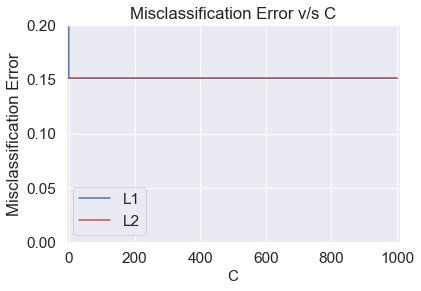

In [103]:
gsv = openfromfile("Log Reg/gsv_w2v")
plot_error_vs_c(gsv)

Accuracy on test set: 82.767%
Precision on test set: 0.829
Recall on test set: 0.998
F1-Score on test set: 0.905
Non Zero weights: 50
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



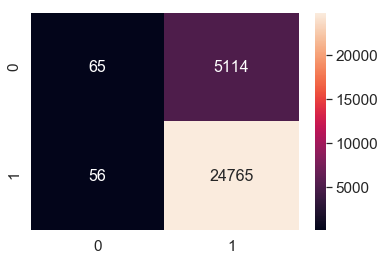

In [104]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1000, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Using Randomized Search CV to find best parameter

In [105]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C': [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
              ,'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
savetofile(gsv,"Log Reg/gsv_w2v_r")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   32.8s finished


Best HyperParameter:  {'penalty': 'l1', 'C': 1}
Best Accuracy: 84.92%


Accuracy on test set: 82.770%
Precision on test set: 0.829
Recall on test set: 0.998
F1-Score on test set: 0.906
Non Zero weights: 50
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



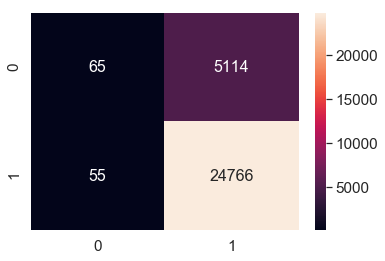

In [106]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

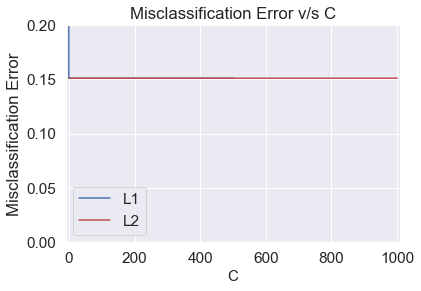

In [107]:
gsv = openfromfile("Log Reg/gsv_w2v_r")
plot_error_vs_c_r(gsv)

Perturbation Test

In [108]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 82.770%
Non Zero weights: 50


In [109]:
from scipy.sparse import find
#Weights before adding random noise
weights1 = find(clf.coef_[0])[2]
print(weights1[:50])

[-0.10887259 -0.38135678 -0.54440432 -0.62474762 -0.58290324  0.82729094
  0.37318887 -0.14312598  1.79728562 -0.24185697  1.30206888 -0.06374474
 -0.42140366  0.44562168 -0.41462793  0.59070843  0.02720041  0.66817006
  0.06745231 -0.0471803   0.34764283 -0.07991434 -0.51778599 -1.35928724
 -0.97040674  1.38475754 -0.29169534  0.43215085 -1.10760963 -0.07651617
  0.96992036  0.49326456 -0.08898601  0.17276198 -0.38458716 -0.41005984
  0.87254049 -1.40353242  0.01914266 -0.28734327 -0.72985314 -0.05845446
 -0.44049008 -0.2402133  -0.62161348 -0.93076621  0.57105144  0.01689085
  0.50626675  0.59356134]


In [110]:
X_train_t = X_train
#Random noise
epsilon = np.random.uniform(low=-0.01, high=0.01, size=(find(X_train_t)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_t)

#Introducing random noise to non-zero datapoints
X_train_t[a,b] = epsilon + X_train_t[a,b]

In [111]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train_t,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 82.767%
Non Zero weights: 50


In [112]:
from scipy.sparse import find
#Weights after adding random noise
weights2 = find(clf.coef_[0])[2]
print(weights2[:50])

[-0.10951596 -0.38223714 -0.54787676 -0.63204614 -0.57809366  0.82381674
  0.37518225 -0.1384137   1.79243491 -0.23459131  1.29589939 -0.06302703
 -0.42207142  0.44532115 -0.406523    0.59083935  0.02610149  0.66602033
  0.07072455 -0.04579984  0.35216794 -0.07370293 -0.51290583 -1.35098056
 -0.96876515  1.38049562 -0.28382821  0.42888316 -1.10495056 -0.07466526
  0.97011046  0.48712753 -0.08896169  0.17429963 -0.3817192  -0.41084069
  0.87311631 -1.39842584  0.02335454 -0.29020507 -0.73309571 -0.05447549
 -0.43316294 -0.23912039 -0.6152925  -0.92645278  0.57179551  0.01550469
  0.51056643  0.58786989]


In [113]:
print(weights2.size)

50


In [114]:
weights_diff = (abs(weights1 - weights2)/weights1) * 100

In [115]:
print(weights_diff[np.where(weights_diff > 30)].size)

0
